Notes: MCC vs Accuracy, source: https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a

    TODO: Intro Para on data for training and testing 
    TODO: Explain CAMELS ratios
    TODO: Explain MCC and why it is important for imbalanced samples like this one
    TODO: Add timer to the Grid Search 
    TODO: Plot the tree and/or feature importances

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, validation_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_curve 
from sklearn.metrics import precision_recall_curve, roc_curve, matthews_corrcoef
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline
# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

### 1. Preprocessing

In [2]:
file_path = "data/camel_data_after2010Q3.csv"
banks_df = pd.read_csv(file_path, index_col=0)

Check if there are any missing values and drop `null`

In [3]:
banks_df.dropna(inplace=True)

Show the features of failed banks (Target of 1) and count them

In [4]:
banks_df.loc[banks_df.Target == 1].count()

AsOfDate    137
Target      137
EQTA        137
EQTL        137
LLRTA       137
LLRGL       137
OEXTA       137
INCEMP      137
ROA         137
ROE         137
TDTL        137
TDTA        137
TATA        137
dtype: int64

Take a copy of predictors and store in X, count all instances available.

In [5]:
X = banks_df[['EQTA', 'EQTL', 'LLRTA', 'LLRGL', 'OEXTA', 'INCEMP', 'ROA', 'ROE', 'TDTL', 'TDTA', 'TATA']].copy()
len(X)

7014

Define the target vector y and reshape it as well.

In [6]:
y = banks_df["Target"].values.reshape(-1, 1)

### 2. Developing basic GBM 

First train/test split, note `random_state=123` for the auditing purposes.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

Creating `StandardScaler` object and fitting, i.e. removing the mean and scaling to unit variance.

In [8]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

Transforming training and testing features data using the fitted scaler.

In [9]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

Preparing for validation: define functions to plot Precision/Recall and ROC/AUC.

### 3. Discovering best parameters with `GridSearch`

In [80]:
param_grid = {'learning_rate': [0.05, 0.1, 0.2, 0.5, 0.7, 0.8, 1], 
             "n_estimators" : [10, 30, 50],
              "max_features": [2, 3, 4, 5],
              "max_depth" : [2, 3, 4]} 

grid = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=7)
grid.fit(X, y.ravel());

grid.best_params_

{'learning_rate': 0.05, 'max_depth': 2, 'max_features': 5, 'n_estimators': 50}

### 4. Evaluating the best GBM model

In [10]:
clf_best = GradientBoostingClassifier(n_estimators=50,
                                     learning_rate=0.05,
                                     max_features=5,
                                     max_depth=2,
                                     random_state=123)

clf_best.fit(X_train_scaled, y_train.ravel())
predictions = clf_best.predict(X_test_scaled)
print("Testing accuracy: {0:.5f}".format(accuracy_score(predictions, y_test)))
pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()}).head(5)

Testing accuracy: 0.98803


,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


Plot precision and recall trade-off over thresholds

Average precision-recall score: 0.66


Text(0.5, 1.0, '2-class Precision-Recall curve: Avg. Precision=0.66')

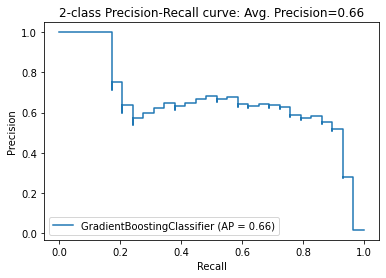

In [11]:
y_score = clf_best.decision_function(X_test_scaled)

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(clf_best, X_test_scaled, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'Avg. Precision={0:0.2f}'.format(average_precision))

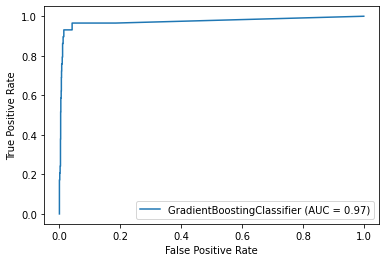

In [24]:
from sklearn.metrics import plot_roc_curve
clf_best_disp = plot_roc_curve(clf_best, X_test_scaled, y_test)
clf_best_disp.plot(ax=ax, alpha=0.8)
plt.show()


Generate the confusion matrix

In [25]:
pd.DataFrame(confusion_matrix(y_test, predictions), index=["Pred 0", "Pred 1"], 
             columns=["Actual 1", "Actual 0"])

,Actual 1,Actual 0
Pred 0,1712,13
Pred 1,8,21


Compute Matthews correlation (MCC)

In [26]:
matthews_corrcoef(y_test, predictions)
print("Matthews Correlation is {0:.3f}".format(matthews_corrcoef(y_test, predictions)))

Matthews Correlation is 0.663


Generate classification report

In [27]:
print("In-Sample Classification Report")
print(classification_report(y_test, predictions))

In-Sample Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1725
           1       0.62      0.72      0.67        29

    accuracy                           0.99      1754
   macro avg       0.81      0.86      0.83      1754
weighted avg       0.99      0.99      0.99      1754



Extracting rules that were learned in training

### 5. Plot the tree and feature importances 

In [28]:
n_classes, n_estimators = clf_best.estimators_.shape

for c in range(n_classes):
    
    for t in range(n_estimators):
        
        dtree = clf_best.estimators_[c, t]
        print("class={}, tree={}: {}".format(c, t, dtree.tree_))

        rules = pd.DataFrame({
            'child_left': dtree.tree_.children_left,
            'child_right': dtree.tree_.children_right,
            'feature': dtree.tree_.feature,
            'threshold': dtree.tree_.threshold,
        })
        
        print(rules)

class=0, tree=0: <sklearn.tree._tree.Tree object at 0x7fd5b2f4d5e0>
   child_left  child_right  feature  threshold
0           1            4        7  -0.106241
1           2            3        1  -0.022965
2          -1           -1       -2  -2.000000
3          -1           -1       -2  -2.000000
4           5            6        0  -1.854326
5          -1           -1       -2  -2.000000
6          -1           -1       -2  -2.000000
class=1, tree=0: <sklearn.tree._tree.Tree object at 0x7fd5b2f4d730>
   child_left  child_right  feature  threshold
0           1            4        0  -1.602776
1           2            3        4  -0.252550
2          -1           -1       -2  -2.000000
3          -1           -1       -2  -2.000000
4           5            6        0  -1.311529
5          -1           -1       -2  -2.000000
6          -1           -1       -2  -2.000000
class=2, tree=0: <sklearn.tree._tree.Tree object at 0x7fd5b2f4d3b0>
   child_left  child_right  feature  thresho

### 6. Out-of-sample GBM testing 

In [29]:
pd.set_option('use_inf_as_na', True)

oos_reports = ['2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4', '2012Q1', '2012Q2', 
               '2012Q3', '2012Q4', '2019Q2']

for report in oos_reports:
    
    oos_df = pd.read_csv('oos/camel_data_after{}_OOS.csv'.format(report))
    oos_df.replace([np.inf, -np.inf], np.nan)
    oos_df.dropna(inplace=True)
    
    y_oos = oos_df['Target']
    X_oos = oos_df[['EQTA', 'EQTL', 'LLRTA', 'LLRGL', 'OEXTA', 'INCEMP', 'ROA', 'ROE', 
                    'TDTL', 'TDTA', 'TATA']].copy()
    X_oos_scaled = X_scaler.transform(X_oos) 
    
    predictions_oos = clf_best.predict(X_oos_scaled)
    mcc = np.round(matthews_corrcoef(y_oos, predictions_oos), 2)
    
    # Generate out-of-sample MCC and classification report 
    print("*" * 55, "\nMatthews Correlation (MCC) for {} is {}".format(report, mcc))
    print("*" * 55,"\nOut-of-sample (OOS) Classification Report for {}:".format(report))
    print(classification_report(y_oos, predictions_oos), "\n\n")
   
  

******************************************************* 
Matthews Correlation (MCC) for 2010Q4 is 0.66
******************************************************* 
Out-of-sample (OOS) Classification Report for 2010Q4:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6779
           1       0.53      0.83      0.65        24

    accuracy                           1.00      6803
   macro avg       0.76      0.92      0.82      6803
weighted avg       1.00      1.00      1.00      6803
 


******************************************************* 
Matthews Correlation (MCC) for 2011Q1 is 0.44
******************************************************* 
Out-of-sample (OOS) Classification Report for 2011Q1:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6713
           1       0.20      1.00      0.33        19

    accuracy                           0.99      6732
   macro avg       0.60 